# Assignment 1
GitHub repository: https://github.com/llull179/Assigments_comsocsci2024.git 

Work distribution: We have all worked together. Mostly the work was done on one computer, where the student shared their screen and we all went through the whole thing step by step.  


In [1]:
from joblib import Parallel, delayed
import joblib
from joblib import Parallel, delayed
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
import numpy as np
import ast
import networkx as nx

In [2]:
def readData():
    try:
        authors = pd.read_csv('data/authors.csv')
    except:
        print('Not found authors.csv')
        authors = None
    try:
        papers = pd.read_csv('data/papers_final.csv')
    except:
        print('Not found papers.csv')
        papers = None
    try:
        abstracts = pd.read_csv('data/abstracts.csv')
    except:
        print('Not found abstracts.csv')
        abstracts = None
    return authors, papers, abstracts 

In [3]:
authors, papers, abstracts  = readData()

## Part I - Obtain authors

In [7]:
def getSoup(url, base_url = "https://ic2s2-2023.org"):
    COMPLETE_LINK = base_url+url
    r = requests.get(COMPLETE_LINK)
    return BeautifulSoup(r.content)

In [4]:
soup = getSoup("/program")
sect = soup.find_all("section", attrs = {"id": "main"})
authorsList = set()

for sect in sect:
    for ul in sect.find_all('ul'):
        for li in ul.find_all('li'):
            authors = li.find("i")
            authors = authors.text.split(",")
            authors = [author.strip() for author in authors]
            authorsList.update(authors)

In [5]:
sect = soup.find_all("section", attrs = {"id": "main"})
for sect in sect:
    for h2 in sect.find_all('h2'):
        if "Chair" in h2.text:
            author = h2.text.split("Chair:")[1].strip()
            authorsList.add(author)

In [6]:
# Optional: get the program committee
soup = getSoup("/program_committee")
sect = soup.find_all("section", attrs = {"id": "main"})
for li in sect[0].find_all('li'):
    authors = li.find("b")
    authorsList.update(authors)


In [7]:
# Optional: get the tutorials teachers
soup = getSoup("/tutorials")
sect = soup.find_all("section", attrs = {"id": "highlights"})
sect = sect[1].find_all("div",attrs = {"class":"container"})[0]
for ul in sect.find_all('ul'):
    for b in ul.find_all('b'):
        for a in b.find_all('a'):
            author = a.text    
            authorsList.add(author)

In [8]:
# check the accurate of name
for i in authorsList:
    if ' ' not in i:
        break;
authorsList.remove(i)
df = pd.DataFrame(authorsList, columns =["Name"] )

In [9]:
# with open('data/authorsList.txt', 'w') as file:
#     for author in authorsList:
#         file.write(author + '\\n')
df.to_csv('data/authorsList.txt', header = False, index = False)

**5. How many unique researchers do you get?**

In [10]:
print("There is a total of", len(authorsList), "researchers.")

There is a total of 1648 researchers.


**6. Explain the process you followed to web-scrape the page. Which choices did you make to accurately retreive as many names as possible? Which strategies did you use to assess the quality of your final list? Explain your reasoning and your choices __(answer in max 150 words)__.**

Considering the structure of the webpage, we scraped each page specifically containing names sepeartely, identified the distinct tags to precisely extract the researcher names, and integrated them subsequently, ensuring we could get as many names as possible. To enhance the list quality, we utilized a set to store the names and avoid the duplicates. Additionly, we check the accuracy of the collected names by confirming that each name is complete with both first and family names.

## Part II

**> 1. What are pros and cons of the custom-made data used in Centola's experiment (the first study presented in the lecture) and the ready-made data used in Nicolaides's study (the second study presented in the lecture)? You can support your arguments based on the content of the lecture and the information you read in Chapter 2.3 of the book __(answer in max 150 words)__.**

The custom-made data can make study result more targeted and detailed since researchers can create and control the experiment process directly, and sample can be controlled, ensuring the revelent between the collected informination and analysis. However, this comes with a high cost to maintain and the sample size is limited. Additionlly, many bias such as non-response bias may arise.

The ready-made data can offers a large sample size and has a time effiency based on the real world condition. But it is hard to access and researchers have limited control for the expirement degin, hence The informination may be incompleted or unrealted, and ethical and privacy issues also need to further consider.

**2. How do you think these differences can influence the interpretation of the results in each study? __(answer in max 150 words)__**

Two types of data may introduce different bias to study results, custom-made data may influence the data collection, while the ready-made data may introduce bias to the researchers. Morever, when handling custom-data, the data limitation and robutness are need to be considered. And researchers should assess the quailty of the data, and undertake additional process to clean the data when working with ready-made data.

## Part III - Obtain author from OpenAlex

In [6]:
def defineURL(type):
    BASE_URL = 'https://api.openalex.org/'
    return BASE_URL + type

In [59]:
with open('data/authorsList.txt', 'r', encoding = 'utf-8') as file:
    authors_list = file.read().splitlines()

print(authors_list[0:5])

['Sander van der Linden', 'Anne C. Kroon', 'Emma Spiro', 'Antonio Bucchiarone', 'Ke Li']


In [60]:
def fetch_results_authors(initial_author):
    URL_W = defineURL('authors')
    selected_vars = 'id,display_name,works_count,works_api_url,summary_stats,last_known_institution'
    i = 1
    def_results = []
    finish = False
    while not finish:
        response = requests.get(URL_W, params={'filter': 'display_name.search:(' + '|'.join(authors_list[initial_author:initial_author+20]) + ')',
                                               'select': selected_vars, 'per-page': '200', 'page': str(i)})
        if response.status_code != 200:
            print('Error at page ' + str(i), 'for authors ' + str(initial_author) + ' to ' + str(initial_author+20), 'and status code ' + str(response.status_code))
            i += 1
        else:
            response = response.json()
            if len(response['results']) == 0:
                finish = True
                break
            def_results += response['results']
            i += 1
    return def_results

initial_authors_range = range(0, len(authors_list), 20)

results = Parallel(n_jobs=-1)(delayed(fetch_results_authors)(initial_author) for initial_author in initial_authors_range)
def_results_authors = [result for sublist in results for result in sublist]

for resp in def_results_authors:
    try:
        resp['country_code'] = resp['last_known_institution']['country_code']
    except:
        resp['country_code'] = np.nan
    try:
        resp['h_index'] = resp['summary_stats']['h_index']
    except:
        resp['h_index'] = 0


print(len(def_results_authors))


36756


In [61]:
authors = pd.DataFrame(def_results_authors, columns = ['id', 'display_name', 'works_count', 'works_api_url','h_index','country_code'])
authors.sample(10)

,id,display_name,works_count,works_api_url,h_index,country_code
18935,https://openalex.org/A5090177789,Jonathan Allen Green,2,https://api.openalex.org/works?filter=author.i...,1,CA
29766,https://openalex.org/A5088346617,Rong Hui Wang,9,https://api.openalex.org/works?filter=author.i...,2,CN
5539,https://openalex.org/A5093329780,Tim Faverjon,1,https://api.openalex.org/works?filter=author.i...,0,FR
32864,https://openalex.org/A5092599183,David De Rothschild,1,https://api.openalex.org/works?filter=author.i...,0,NaN
17098,https://openalex.org/A5025619270,David Mínguez García,1,https://api.openalex.org/works?filter=author.i...,0,NaN
4863,https://openalex.org/A5056300177,Marcelo A. de A. e Silva,1,https://api.openalex.org/works?filter=author.i...,1,BR
18375,https://openalex.org/A5047256827,Mário Castro Soares,1,https://api.openalex.org/works?filter=author.i...,0,NaN
26818,https://openalex.org/A5006476009,Qin Li,1,https://api.openalex.org/works?filter=author.i...,1,CN
22403,https://openalex.org/A5078872459,Ángel Sánchez-Trancón,1,https://api.openalex.org/works?filter=author.i...,0,NaN
2837,https://openalex.org/A5062215053,Xiao xian Zhang,1,https://api.openalex.org/works?filter=author.i...,1,CN


#### Let's delte repited authors
- We first delete all the repited id. (Not necessary any ordering because all the rows are exactly the same)
- Later we delete all the repited display_name. (We order by h_index and delete the lowest one)

In [62]:
authors = authors.drop_duplicates(subset = 'id')

In [63]:
authors[authors.display_name.duplicated(keep=False)].sort_values(by='display_name').head(6)

,id,display_name,works_count,works_api_url,h_index,country_code
19337,https://openalex.org/A5035872740,A Lee Edward,3,https://api.openalex.org/works?filter=author.i...,0,NaN
19335,https://openalex.org/A5085785026,A Lee Edward,1,https://api.openalex.org/works?filter=author.i...,0,NaN
34246,https://openalex.org/A5040705130,A.-M. Cohen-Jonathan,2,https://api.openalex.org/works?filter=author.i...,2,FR
34532,https://openalex.org/A5070416321,A.-M. Cohen-Jonathan,1,https://api.openalex.org/works?filter=author.i...,0,NaN
6263,https://openalex.org/A5065690741,AI Xue-lin,1,https://api.openalex.org/works?filter=author.i...,0,NaN
6318,https://openalex.org/A5014271391,AI Xue-lin,1,https://api.openalex.org/works?filter=author.i...,0,NaN


In [64]:
authors = authors.sort_values(by='h_index', ascending=False).drop_duplicates(subset ='display_name',keep='first')

In [92]:
strange_carachters = ['\*','&','%','\[','\]','\{','\}','<','>','\/','@','\^','~','`',':',';','\.','\!','\?','"','#','\$','\=','\+']
numbers = ['0','1','2','3','4','5','6','7','8','9']
for char in strange_carachters+numbers:
    # print(char, authors_cop.shape[0])
    authors = authors[~authors['display_name'].str.contains(char)]


In [93]:
authors.sort_values(by='display_name').head(5)

,id,display_name,works_count,works_api_url,h_index,country_code
16208,https://openalex.org/A5053443984,-ZHANG-Rong LI-Hui WANG-Zhennan,1,https://api.openalex.org/works?filter=author.i...,0,NaN
24762,https://openalex.org/A5059360190,A Brown Taylor,3,https://api.openalex.org/works?filter=author.i...,0,NaN
24841,https://openalex.org/A5075662148,A F de Souza Miguel,1,https://api.openalex.org/works?filter=author.i...,0,NaN
19335,https://openalex.org/A5085785026,A Lee Edward,1,https://api.openalex.org/works?filter=author.i...,0,NaN
36587,https://openalex.org/A5075179024,A M Gregorio López Moreira,4,https://api.openalex.org/works?filter=author.i...,1,DE


In [94]:
authors.to_csv('data/authors.csv', index=False)

# Week 3 - Searching works

In [95]:
authors = pd.read_csv('data/authors.csv')
print(authors.shape)

(27562, 6)


In [8]:
# Get only those authors with more than 5 works and less than 5000
id_list = authors[(authors['works_count'] > 5)  & (authors['works_count']<5000)]['id'].tolist()
print("There are", len(id_list), "authors with more than 5 works and less than 5000")

There are 4270 authors with more than 5 works and less than 5000


In [169]:
from joblib import Parallel, delayed
# Define a function to fetch results for a given range of initial authors
def fetch_results(initial_author):
    URL_W = defineURL('works')
    selected_vars = 'id,publication_year,cited_by_count,title,abstract_inverted_index,authorships,topics'
    i = 1
    def_results = []
    finish = False
    while not finish:
        response = requests.get(URL_W, params={'filter': 'authorships.author.id:(' + '|'.join(id_list[initial_author:initial_author+20]) 
                                               + '),cited_by_count:>10,authors_count:<10',
                                               'select': selected_vars, 'per-page': '200', 'page': str(i)})
        if response.status_code != 200:
            print('Error at page ' + str(i), 'for authors ' + str(initial_author) + ' to ' + str(initial_author+20), 'and status code ' + str(response.status_code))
            i += 1
        else:
            response = response.json()
            if len(response['results']) == 0:
                finish = True
                break
            def_results += response['results']
            i += 1
    return def_results

# Define the range of initial authors
initial_authors_range = range(0, len(id_list), 20)

# Parallelize the loop using joblib
results = Parallel(n_jobs=-1)(delayed(fetch_results)(initial_author) for initial_author in initial_authors_range)

# Flatten the results list
def_results_works = [result for sublist in results for result in sublist]

In [170]:
for resp in def_results_works:
    resp['author_id'] = [author['author']['id'] for author in resp['authorships']]
    try:
        resp['themes'] = [resp['topics'][topic]['field']['display_name'] for topic in range(len(resp['topics']))]
    except:
        resp['themes'] = []
    # del resp['authorships']
    # del resp['topics']

print('Total of works:', len(def_results_works))

Total of works: 33450


In [171]:
papers = pd.DataFrame(def_results_works, columns = ['id','publication_year','author_id','cited_by_count','title','themes'])
abstracts = pd.DataFrame(def_results_works, columns = ['id','abstract_inverted_index'])

In [172]:
papers = papers.drop_duplicates(subset='id')
compSoc = ["Sociology", "Psychology", "Economics","Economics, Econometrics and Finance", "Political Science", "Scoial Sciences"]
quanDisc = ["Mathematics", "Physics and Astronomy", "Computer Science","Physics"]
papers['toGet'] = papers['themes'].apply(lambda x:  any(elem in x for elem in compSoc) and any(elem in x for elem in quanDisc))

In [174]:
# We delete all the works that are not releted with the asked themes
papers_final = papers.copy()
papers_final = papers_final[papers['toGet']]
papers_final.drop(columns=['toGet'], inplace=True)
papers.drop(columns=['toGet'], inplace=True)

C:\Users\lluis\AppData\Local\Temp\ipykernel_16948\575269461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  papers_final.drop(columns=['toGet'], inplace=True)


In [177]:
papers.to_csv('data/papers.csv', index = False)
papers_final.to_csv('data/papers_final.csv', index = False)
abstracts.to_csv('data/abstracts.csv', index = False)

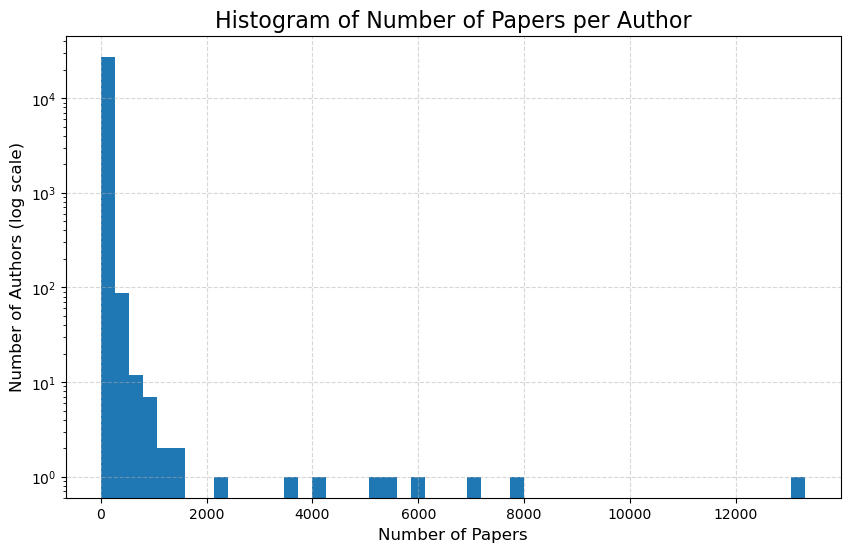

In [9]:

plt.figure(figsize=(10, 6))

# Create the histogram
plt.hist(authors['works_count'], bins=50, log=True)
plt.grid(True, linestyle='--', alpha=0.5)

# Set the title and labels
plt.title('Histogram of Number of Papers per Author', fontsize=16)
plt.xlabel('Number of Papers', fontsize=12)
plt.ylabel('Number of Authors (log scale)', fontsize=12)

# Show the plot
plt.show()

**Dataset summary.- How many works are listed in your *IC2S2 papers* dataframe? How many unique researchers have co-authored these works?**

In [20]:
print('There are', len(papers_final), ' works listed in IC2S2 papers.')

NameError: name 'papers_final' is not defined

**Efficiency in code.- Describe the strategies you implemented to make your code more efficient. How did your approach affect your code's execution time?** __(answer in max 150 words)__

We implemented the parallel function to enabled the concurrent execution of requests to reduce the workloads and set the page limitition to obtain more works in per request. Additionally, we used filter parameters, querying multiple works in one request, which all improve the execution time significantly.


**Filtering Criteria and Dataset Relevance- Reflect on the rationale behind setting specific thresholds for the total number of works by an author, the citation count, the number of authors per work, and the relevance of works to specific fields. How do these filtering criteria contribute to the relevance of the dataset you compiled? Do you believe any aspects of Computational Social Science research might be underrepresented or overrepresented as a result of these choices? __(answer in max 150 words)__**

We specified these filtering criteria to enhance the refine the data, prioritizing the relevance and accuracy. Restricting the total number of works of the author can capture the authors properly, the works attributions such as citation counts and the number of authors per work can ensure the overall quality and completeness of the seected works. The research may be underrepresented or overrepresented, since if the thresholds are set so strict, some relevant variables might be ignored and potentially infulence the result, while if the thresholds are very low, many unrelated variables will be included, whcih may lead a reduction in the precision of the results.

---

# Part 4

In [10]:
authors, papers, abstracts = readData()

### INCLUDE HISTOGRAMS

In [11]:
#Convert Author_id to list
papers['author_id'] = papers['author_id'].apply(lambda x: ast.literal_eval(x))

In [12]:
weighted_edgelist = {}

for author in papers['author_id']:
    for i in range(len(author)):
        for j in range(i+1, len(author)):
            pair = tuple(sorted([author[i], author[j]]))
            if pair in weighted_edgelist:
                weighted_edgelist[pair] += 1
            else:
                weighted_edgelist[pair] = 1

weighted_edgelist = [(pair[0], pair[1], count) for pair, count in weighted_edgelist.items()]
print(weighted_edgelist[0:5])

[('https://openalex.org/A5014662127', 'https://openalex.org/A5061287527', 3), ('https://openalex.org/A5014662127', 'https://openalex.org/A5046546654', 2), ('https://openalex.org/A5046546654', 'https://openalex.org/A5061287527', 2), ('https://openalex.org/A5064290037', 'https://openalex.org/A5090631705', 1), ('https://openalex.org/A5023975998', 'https://openalex.org/A5064290037', 1)]


In [13]:
G = nx.Graph()
G.add_weighted_edges_from(weighted_edgelist)


In [16]:
for node in G.nodes():
    print(node)
    print(authors.loc[authors['id'] == str(node), 'display_name'])
    break

https://openalex.org/A5014662127
21    Alain Barrat
Name: display_name, dtype: object


In [17]:
for node in G.nodes():
    # Retrieve the author's display name, country, citation count, and year of first publication
    display_name = authors.loc[authors['id'] == node, 'display_name']
    country = authors.loc[authors['id'] == node, 'country_code']
    citation_count = authors.loc[authors['id'] == node, 'works_count']
    # first_publication_year = papers.loc[papers['author_id'].apply(lambda x: node in ast.literal_eval(x)), 'publication_year'].min()
    
    # Add the attributes to the node
    G.nodes[node]['display_name'] = display_name
    G.nodes[node]['country'] = country
    G.nodes[node]['citation_count'] = citation_count
    # G.nodes[node]['first_publication_year'] = first_publication_year

# Save the network as a JSON file
nx.write_adjlist(G, './data/network.json')


In [18]:
G = nx.read_adjlist('./data/network.json')


Total number of nodes: 1664
Total number of links: 4313


1. **Network Metrics:**

- What is the total number of nodes (authors) and links (collaborations) in the network?

In [ ]:
print("total number of nodes:",G.number_of_nodes())
print("total number of links:",G.number_of_edges())

total number of nodes: 2382
total number of links: 6219


- Calculate the network's density (the ratio of actual links to the maximum possible number of links). Would you say that the network is sparse? Justify your answer.

In [ ]:
print("network's density:",nx.density(G))

network's density: 0.002193054375688305


The density is approximately 0.0022, close to 0, hence the network is sparse.

- Is the network fully connected (i.e., is there a direct or indirect path between every pair of nodes within the network), or is it disconnected?

In [ ]:
if nx.is_connected(G) == "True":
    print("The network fully connected.")
else:
    print("The network is disconnected.")

The network is disconnected.


- If the network is disconnected, how many connected components does it have? A connected component is defined as a subset of nodes within the network where a path exists between any pair of nodes in that subset.

In [ ]:
components = list(nx.connected_components(G))
print("it have",len(components),"connected components")

it have 198 connected components


- How many isolated nodes are there in your network?  An isolated node is defined as a node with no connections to any other node in the network.

In [ ]:
length = 0
for n in G.nodes():
    if G.degree(n) == 0:
        length+=1
print("There are", length, "isolated nodes")

There are 0 isolated nodes


- Discuss the results above on network density, and connectivity. Are your findings in line with what you expected? Why?  __(answer in max 150 words)__

It has been proved that the graph has not a really high conectivty, what is more, there is almost 200 connected components, but in the other hand, there is not any isolated node. It is not waht we were expecting at the beggining, but also can make sense, there is no isolated authors beucause all of them at least have worked with some other authors at some point, a logical fact taking in mind that is typical make research in teams.

2. **Degree Analysis:**
- Compute the average, median, mode, minimum, and maximum degree of the nodes. Perform the same analysis for node strength (weighted degree). What do these metrics tell us about the network? __(answer in max 150 words)__

In [ ]:
degree = dict(G.degree())
print("average of degree:", np.mean(list(degree.values())))
print("median of degree:", np.median(list(degree.values())))
# print("mode of degree:", np.median(list(degree.values())))\
print("minimum of degree:", min(list(degree.values())))
print("maximum of degree:", max(list(degree.values())))
weighted_degree = dict(G.degree(weight = 'citation_count'))
print("average of weighted degree:", np.mean(list(weighted_degree.values())))
print("median of weighted degree:", np.median(list(weighted_degree.values())))
print("minimum of weighted degree:", min(list(weighted_degree.values())))
print("maximum of weighted degree:", max(list(weighted_degree.values())))


average of degree: 5.221662468513854
median of degree: 4.0
minimum of degree: 1
maximum of degree: 66
average of weighted degree: 5.221662468513854
median of weighted degree: 4.0
minimum of weighted degree: 1
maximum of weighted degree: 66


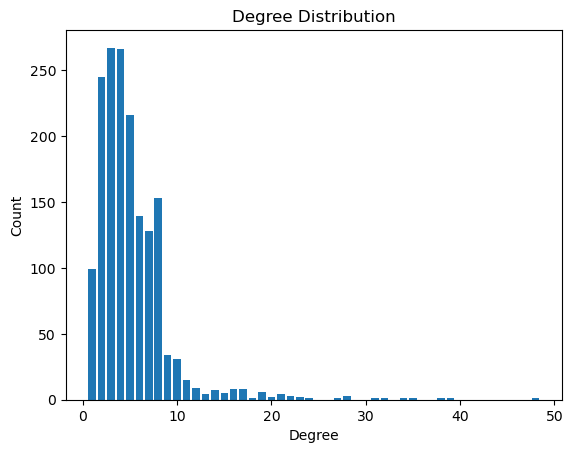

In [24]:
degree_counts = pd.Series(dict(G.degree())).value_counts()
plt.bar(degree_counts.index, degree_counts.values)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution')
plt.show()


 We can clearly see that tehere is not a really high degree average on the network, also it is worth to mention that there is some authors with a high ammount of connections although the average is low. Even this, the low median can be due to the repetivity of the authors colaborations, because authors can keep working with the same peolpe, this can be explained because especialised profesionals keep working in same areas that can be shared with other authors. That can be comproveted in the image below.

3. **Top Authors:**
- Identify the top 5 authors by degree. What role do these node play in the network? 

These nodes play a role of bridge between the different components of the network. They create a higher connectivity and can be important for the network to be connected.

In [43]:
top_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:5]
top_nodes = [node[0] for node in top_nodes]
for node in top_nodes:
    print(node)
    print(authors.loc[authors['id'] == str(node), 'display_name'])
    print('_'*50)


https://openalex.org/A5005493160
25    Mariano Sigman
Name: display_name, dtype: object
__________________________________________________
https://openalex.org/A5016268748
76    Fabrizio Lillo
Name: display_name, dtype: object
__________________________________________________
https://openalex.org/A5019170728
43    Manlio De Domenico
Name: display_name, dtype: object
__________________________________________________
https://openalex.org/A5076683363
80    Sacha Epskamp
Name: display_name, dtype: object
__________________________________________________
https://openalex.org/A5070657345
88    Vittorio Loreto
Name: display_name, dtype: object
__________________________________________________


In [44]:
authors[authors.id.isin(top_nodes)]

,id,display_name,works_count,works_api_url,h_index,country_code
25,https://openalex.org/A5005493160,Mariano Sigman,271,https://api.openalex.org/works?filter=author.i...,62,ES
43,https://openalex.org/A5019170728,Manlio De Domenico,273,https://api.openalex.org/works?filter=author.i...,51,IT
76,https://openalex.org/A5016268748,Fabrizio Lillo,471,https://api.openalex.org/works?filter=author.i...,43,IT
80,https://openalex.org/A5076683363,Sacha Epskamp,169,https://api.openalex.org/works?filter=author.i...,42,NL
88,https://openalex.org/A5070657345,Vittorio Loreto,254,https://api.openalex.org/works?filter=author.i...,40,IT


**Research these authors online. What areas do they specialize in? Do you think that their work aligns with the themes of Computational Social Science? If not, what could be possible reasons? __(answer in max 150 words)__**

The main fie,ds of the top five authors are: neuroscience, physics, mathematics, data science and modeling. We could say taht this topics are not exaclty waht we could expect in Computational Social Science, but we can say that the fields are really broad and also very flexible and universal. For this reason, we can say that we can find this fields in any type of research, including Computational Social Science research.

In [36]:
from netwulf import visualize

nw, confg = visualize(G)


(None, None)

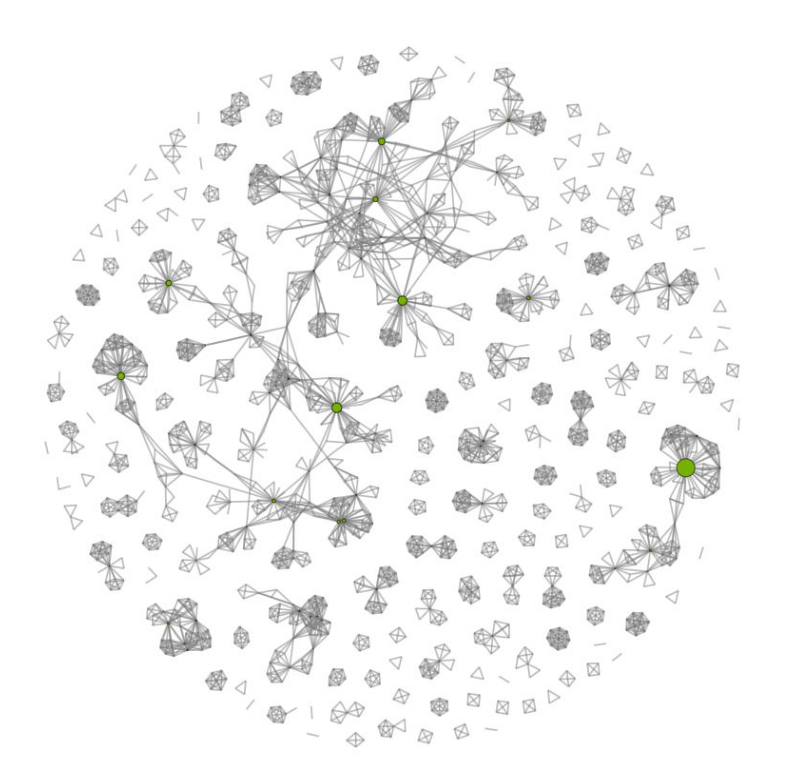

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
plt.figure(figsize=(10, 10))
img = mpimg.imread('./Network_connectivity.JPG')

# Display the image
plt.imshow(img)
plt.axis('off')  # Remove axis ticks and labels
plt.show()
